In [1]:
import os

import joblib
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
from transformers import EarlyStoppingCallback, IntervalStrategy
from transformers import TrainingArguments, Trainer

print(os.listdir("../data"))
import warnings
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore')


E:\Project\IMDB\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['IMDB Dataset.csv']


In [2]:
models_path = "../models/"
X_train, X_test, y_train, y_test = joblib.load(models_path + "split_data.pkl")

In [3]:
# Validation set
X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=42,
    stratify=y_train
)

In [4]:
MODEL_NAME = "distilbert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [5]:
y_train_num = y_train.map({'positive': 1, 'negative': 0})
y_test_num = y_test.map({'positive': 1, 'negative': 0})
y_val_num = y_val_dl.map({'positive': 1, 'negative': 0})

In [6]:
def bert_encode(texts, max_len=128):
    return tokenizer(
        texts,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

X_train_bert = bert_encode(X_train.tolist())
X_test_bert = bert_encode(X_test.tolist())
X_val_bert = bert_encode(X_val_dl.tolist())

In [7]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [8]:
train_dataset = SentimentDataset(X_train_bert, y_train_num.reset_index(drop=True))
test_dataset = SentimentDataset(X_test_bert, y_test_num.reset_index(drop=True))
val_dataset = SentimentDataset(X_val_bert, y_val_num.reset_index(drop=True))

In [9]:
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2  # positive and negative
)

# freeze embeddings
# for param in model.bert.embeddings.parameters():
#     param.requires_grad = False

# Switch the model to GPU if available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Loading weights: 0it [00:00, ?it/s]
BertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                                                                      | Status     | 
-------------------------------------------------------------------------+------------+-
distilbert.transformer.layer.{0, 1, 2, 3, 4, 5}.attention.out_lin.bias   | UNEXPECTED | 
distilbert.transformer.layer.{0, 1, 2, 3, 4, 5}.output_layer_norm.weight | UNEXPECTED | 
distilbert.transformer.layer.{0, 1, 2, 3, 4, 5}.sa_layer_norm.weight     | UNEXPECTED | 
distilbert.transformer.layer.{0, 1, 2, 3, 4, 5}.attention.out_lin.weight | UNEXPECTED | 
distilbert.transformer.layer.{0, 1, 2, 3, 4, 5}.attention.k_lin.weight   | UNEXPECTED | 
distilbert.transformer.layer.{0, 1, 2, 3, 4, 5}.output_layer_norm.bias   | UNEXPECTED | 
vocab_layer_norm.weight  

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [10]:
training_args = TrainingArguments(
    output_dir="./bert_results",
    eval_strategy=IntervalStrategy.STEPS,
    eval_steps=500,
    save_total_limit=5,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=200,
    report_to="none"
)


In [11]:
def compute_metrics(p):
    logits = p.predictions
    labels = p.label_ids
    pred = np.argmax(logits, axis=1)

    return {
        "accuracy": accuracy_score(labels, pred),
        "f1": f1_score(labels, pred)
    }

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [13]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
500,0.702643,0.694272,0.500000,0.666667
1000,0.695013,0.581166,0.697000,0.687951
1500,0.522013,0.457140,0.785500,0.751160
2000,0.453557,0.367975,0.831750,0.843014
2500,0.418709,0.404788,0.820250,0.839473
3000,0.378181,0.331340,0.860000,0.866157
3500,0.362496,0.317839,0.869250,0.863979
4000,0.344720,0.333165,0.860500,0.870774
4500,0.346061,0.283556,0.888750,0.889386
5000,0.327599,0.275490,0.890750,0.893180


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]
There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer

TrainOutput(global_step=7500, training_loss=0.41058680114746093, metrics={'train_runtime': 21362.9596, 'train_samples_per_second': 5.617, 'train_steps_per_second': 0.351, 'total_flos': 7893331660800000.0, 'train_loss': 0.41058680114746093, 'epoch': 3.0})

- Consume a lot of times
- It's not that high if compare with other model

In [14]:
bert_results = trainer.evaluate()
bert_results

{'eval_loss': 0.2570444643497467,
 'eval_accuracy': 0.90125,
 'eval_f1': 0.9022035157217133,
 'eval_runtime': 131.1755,
 'eval_samples_per_second': 30.494,
 'eval_steps_per_second': 1.906,
 'epoch': 3.0}

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      5000
           1       0.84      0.85      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



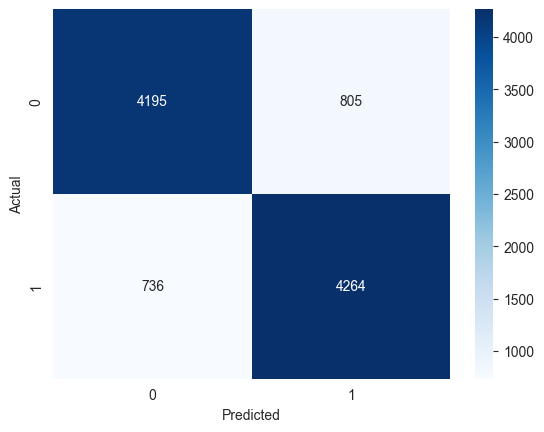

In [15]:
preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(y_test_num, y_pred))
cm = confusion_matrix(y_test_num, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

- The accuracy on test set is not that high

In [16]:
# Test on some review

test_reviews = [
    "It wasn’t what I expected, but I kept thinking about it afterward.",
    "Some parts felt slow, yet I didn’t really want it to end.",
    "I’m not sure I liked it, though I can see why others would.",
    "It had its moments, even if I wouldn’t rush to experience it again.",
    "Strangely frustrating, but not entirely without charm."
]

test_input = bert_encode(test_reviews)

In [17]:
# Check test sentiment
model.eval()
with torch.no_grad():
    outputs = model(**test_input)
    predictions = torch.argmax(outputs.logits, dim=1)

label_map = {0: "Negative", 1: "Positive"}
pred_labels = [label_map[p.item()] for p in predictions]

for review, label in zip(test_reviews, pred_labels):
    print("Review:")
    print(review)
    print("Predicted Sentiment:", label)
    print("-" * 50)


Review:
It wasn’t what I expected, but I kept thinking about it afterward.
Predicted Sentiment: Negative
--------------------------------------------------
Review:
Some parts felt slow, yet I didn’t really want it to end.
Predicted Sentiment: Negative
--------------------------------------------------
Review:
I’m not sure I liked it, though I can see why others would.
Predicted Sentiment: Positive
--------------------------------------------------
Review:
It had its moments, even if I wouldn’t rush to experience it again.
Predicted Sentiment: Positive
--------------------------------------------------
Review:
Strangely frustrating, but not entirely without charm.
Predicted Sentiment: Negative
--------------------------------------------------


In [18]:
# Check confidence for each reviews
probs = torch.softmax(outputs.logits, dim=1)

for review, prob in zip(test_reviews, probs):
    print(review)
    print("Positive confidence:", prob[1].item())
    print("Negative confidence:", prob[0].item())
    print("-" * 50)


It wasn’t what I expected, but I kept thinking about it afterward.
Positive confidence: 0.15246401727199554
Negative confidence: 0.847536027431488
--------------------------------------------------
Some parts felt slow, yet I didn’t really want it to end.
Positive confidence: 0.011351697146892548
Negative confidence: 0.9886483550071716
--------------------------------------------------
I’m not sure I liked it, though I can see why others would.
Positive confidence: 0.8697175979614258
Negative confidence: 0.13028238713741302
--------------------------------------------------
It had its moments, even if I wouldn’t rush to experience it again.
Positive confidence: 0.8889837265014648
Negative confidence: 0.11101622134447098
--------------------------------------------------
Strangely frustrating, but not entirely without charm.
Positive confidence: 0.013936012051999569
Negative confidence: 0.9860639572143555
--------------------------------------------------


Day 9 - BERT
- BERT takes a lot of time to train
- It not that better than other model but consider the training time